<a href="https://colab.research.google.com/github/ChJazhiel/VAE_NBody/blob/main/VAE_HALO_Finder_Isidro_24_April_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

from PIL import Image
import cv2
import skimage.measure
import skimage.io

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

#tf.debugging.set_log_device_placement(False)

2.15.0
Num GPUs Available:  1


True

In [ ]:
! git clone https://github.com/ChJazhiel/VAE_NBody.git

fatal: destination path 'VAE_NBody' already exists and is not an empty directory.


In [ ]:
# root_dir = "/home/isidro/Documents/github/"
# /content/VAE_NBody/Projections_axis_off/D18_x_axis_off_Projection_x_density_density.png
image_dir = "/content/VAE_NBody/Projections_axis_off"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]


image_halos_dir = "/content/VAE_NBody/HALOS_Axis_off/Axis_off"
images_halos = [os.path.join(image_halos_dir, image) for image in os.listdir(image_halos_dir)]
images_halos[:2]

['/content/VAE_NBody/HALOS_Axis_off/Axis_off/D35_y_axis_off_Projection_y_density_density.png',
 '/content/VAE_NBody/HALOS_Axis_off/Axis_off/D38_x_axis_off_Projection_x_density_density.png']

In [ ]:
 len(images_halos), type(images_halos)

(78, list)

In [ ]:
shuffle_idx = np.random.permutation(len(images))
shuffle_idx

array([50, 24, 28, 15, 34, 67, 52, 51, 41, 42, 38, 53, 75, 10,  0, 74, 14,
       60, 40, 73, 54, 77, 65, 26, 31, 32, 12, 58, 37,  2, 43,  1, 68, 44,
       13,  4, 66, 48, 56, 62, 20, 49, 19, 21,  8, 36, 35, 64, 76, 61, 25,
       57, 16, 70, 33, 23, 27, 69, 47, 17, 72,  5, 22, 71, 59, 45, 46, 55,
       39,  3, 18, 29, 11,  9, 63, 30,  6,  7])

In [ ]:
images = [images[idx] for idx in shuffle_idx]
images_halos = [images_halos[idx] for idx in shuffle_idx]

In [ ]:
# preprocess
image_size = 256

## tf.io is an api for image processing



#TensorFlow I/O is a collection of file systems and file formats that are not available in TensorFlow's built-in
#support.

#It provides useful extra Dataset, streaming, and file system extensions, and is maintained by TensorFlow SIG-IO.

#### add a tf.crop in order to resize and add the 3 color channels


def preprocess(image):
    image = skimage.io.imread(image)
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
    image = np.reshape(image, (image_size, image_size, 4))
    # image = tf.io.decode_jpeg(image)
    # #image = tf.cast(image, tf.float32)
    # image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    # # image = tf.image.random_crop(image,  size=[256,256,4])
    # image = tf.reshape(image, shape = (image_size, image_size, 4,))


    ## add random rotation
    image = tf.image.rot90(image, k=3, name=None)
    image = image[:,:,1]
    return image

In [ ]:
training_dataset = [preprocess(image) for image in images]
training_dataset_halos = [preprocess(image) for image in images_halos]

In [ ]:
np.shape(training_dataset), np.shape(training_dataset_halos)

((78, 256, 256), (78, 256, 256))

In [ ]:
noisy_training_dataset = training_dataset + 0.1*np.random.rand(78,256,256)
noisy_training_dataset_halos = training_dataset_halos + 0.1*np.random.rand(78,256,256)

In [ ]:
#np.shape(training_dataset)

In [ ]:
training_dataset = np.concatenate((training_dataset, noisy_training_dataset), axis=0)
training_dataset_halos = np.concatenate((training_dataset_halos, noisy_training_dataset_halos), axis=0)

In [ ]:
#training_dataset_halos = np.concatenate((training_dataset_halos, noisy_training_dataset_halos), axis=0)

In [ ]:
np.shape(training_dataset), np.shape(training_dataset_halos)

((156, 256, 256), (156, 256, 256))

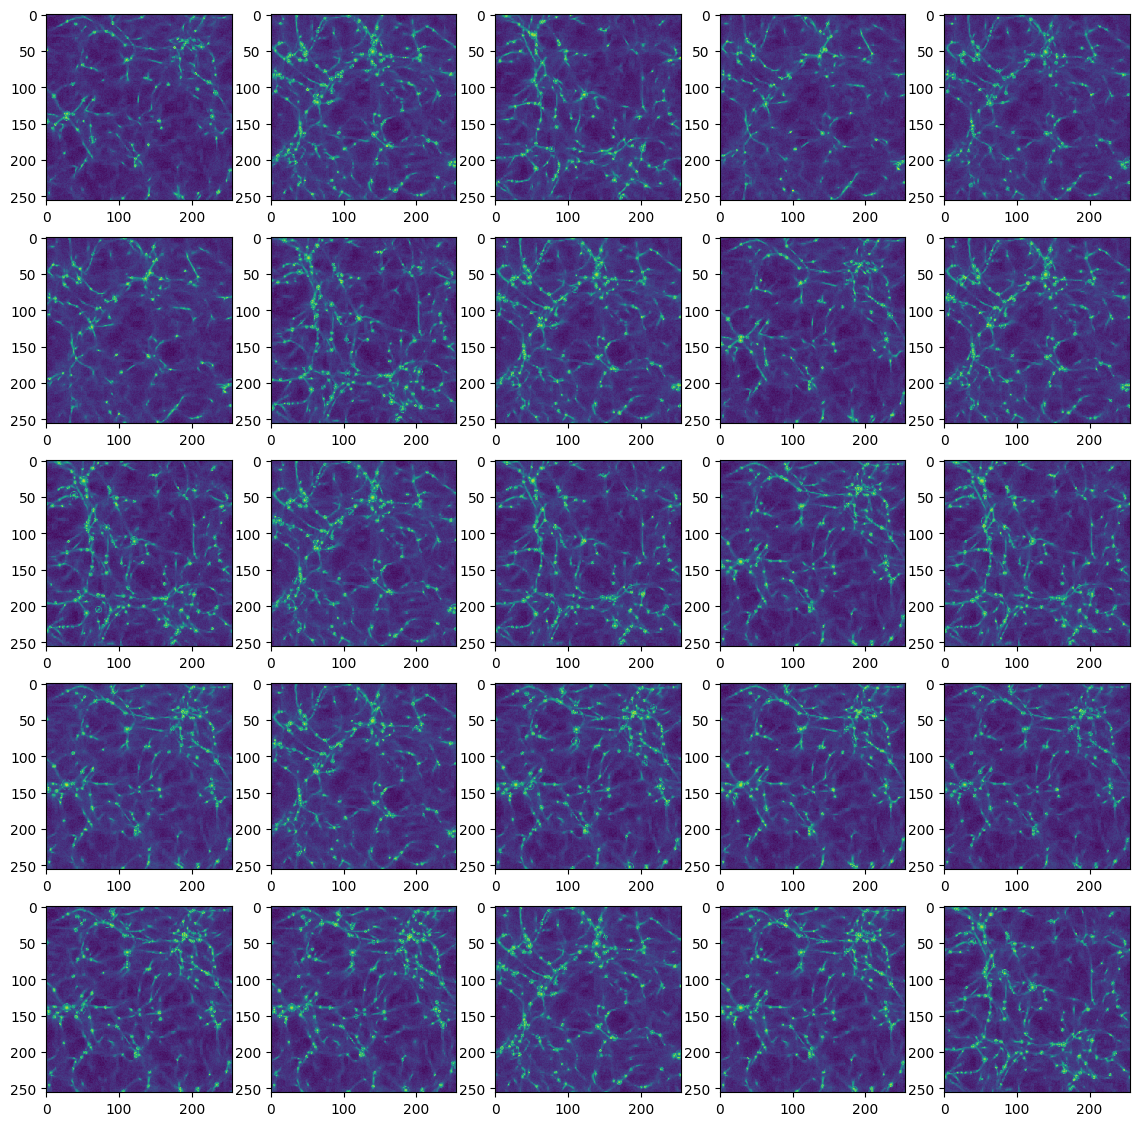

In [ ]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
# training_dataset[:25]

idx = 0
# for img in sample:
  # img = img[0, :, :, :]
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(noisy_training_dataset_halos[idx][:, :,])
        idx += 1

In [ ]:
## Necessary imports

from keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.optimizers import Adam

In [ ]:
# np.shape(training_dataset)
training_dataset = np.reshape(training_dataset, (len(training_dataset),1,image_size,image_size,1))
training_dataset_halos = np.reshape(training_dataset_halos, (len(training_dataset),1,image_size,image_size,1))

In [ ]:
latent_dim = 64

In [ ]:
# Define the encoder
encoder_input = keras.Input(shape=(1, image_size, image_size, 1))
x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(encoder_input)
x = layers.Conv2D(128, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(512, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [ ]:
# Reparameterization trick to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")


In [ ]:
# Define the decoder
latent_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(100, activation="relu")(latent_input)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(32 * 32 * image_size, activation="relu")(x)
x = layers.Reshape((32, 32, image_size))(x)
x = layers.Conv2DTranspose(256, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(x)
decoder_output = layers.Conv2DTranspose(1, (3,3), activation="linear", padding="same")(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")

In [ ]:
# Define the VAE as a whole
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Create the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(0.001, 0.3))


In [ ]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 256, 256, 1)]     0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1, 128, 128, 64)      640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1, 64, 64, 128)       73856     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 1, 32, 32, 256)       295168    ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               6500      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 262144)            26476544  
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 256)       590080    
 anspose)                                                        
                                                           

In [ ]:
#  vae.fit(x=training_dataset, y=training_dataset_halos, epochs=10, batch_size=8)
history = vae.fit(x=training_dataset, y=training_dataset_halos, epochs=40, batch_size=8)

In [ ]:
plt.plot(history.history["reconstruction_loss"])

In [ ]:
plt.plot(history.history["kl_loss"])

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["reconstruction_loss"])

In [ ]:
random_vector_1 = tf.random.normal(shape = (64, latent_dim,))
random_vector_2 = tf.random.normal(shape = (64, latent_dim,))


generated_images_1 = vae.decoder.predict(random_vector_1)
generated_images_2 = vae.decoder.predict(random_vector_2)
len

In [ ]:
np.shape(random_vector_1), type(random_vector_1)

In [ ]:
np.shape(generated_images_2), type(generated_images_2)

In [ ]:
# Plot the generated images
n = len(generated_images_1)
rows = 8
cols = n // rows

plt.figure(figsize=(10, 10))
for i in range(n):
    #plt.subplot(rows, cols, i + 1)
    plt.imshow(generated_images_1[i])
    #plt.imshow(generated_images_2[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

# visualize some of them
#fig, axes = plt.subplots(5,5, figsize = (14,14))
# training_dataset[:25]

#idx = 0
# for img in sample:
  # img = img[0, :, :, :]
#for row in range(5):
 #   for column in range(5):
 #       axes[row, column].imshow(generated_images_1[i])
        #axes[row, column].imshow(generated_images_2)
        #idx += 1
#plt.show()

In [ ]:
# Plot the generated images
n = len(generated_images_1)
rows = 8
cols = n // rows

plt.figure(figsize=(10, 10))
for i in range(n):
    #plt.subplot(rows, cols, i + 1)
    #plt.imshow(generated_images_1[i])
    plt.imshow(generated_images_2[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
###Graficar media y varianza

## cambiar tamaño del filtro a 3x3 o 5x5

In [ ]:
tf.shape(z_mean)

In [ ]:
print(z_mean)

In [ ]:
print(z)

In [ ]:
latent_dim = latent_dim

random_vector_1 = tf.random.normal(shape = (8, latent_dim,))
random_vector_2 = tf.random.normal(shape = (8, latent_dim,))


generated_images_1 = vae.decoder.predict(random_vector_1)
generated_images_2 = vae.decoder.predict(random_vector_2)

encoded = vae.encoder.predict(training_dataset)

z_mean_values = encoded[0]  # Extract z_mean values
z_log_var_values = encoded[1]  # Extract z_log_var values

# Now you can plot z_mean and z_log_var in a 2D plot
plt.scatter(z_mean_values[:, 0], z_mean_values[:, 1], c='r', label='z_mean')
plt.scatter(z_log_var_values[:, 0], z_log_var_values[:, 1], c='b', label='z_log_var')
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

## Using an image without halos

In [ ]:
file = '/content/VAE_NBody/Projections_axis_off/D18_x_axis_off_Projection_x_density_density.png'
test_image = preprocess(file)
test_image = np.reshape(test_image, (1, image_size, image_size, 1))
np.shape(test_image)

In [ ]:
n = len(test_image)
rows = 8
cols = n // rows

plt.figure(figsize=(10, 10))
for i in range(n):
    #plt.subplot(rows, cols, i + 1)
    #plt.imshow(generated_images_1[i])
    plt.imshow(test_image[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_pred = encoder.predict(test_image)
np.shape(test_pred)

In [ ]:
# test_tensor =  tf.convert_to_tensor(test_pred)
# np.shape(test_tensor), type(test_tensor)

In [ ]:
test_pred2 = decoder.predict(test_pred[2])
np.shape(test_pred2)

In [ ]:
n = len(test_pred2)
rows = 8
cols = n // rows
plt.figure(figsize=(10, 10))

#for i in range(n):
    #plt.imshow(generated_images_1[i])
plt.imshow(test_pred2[0,:,:,0])
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# prompt: from the above code try to generate a histogram of the tensor recently plotted as image

import matplotlib.pyplot as plt
import numpy as np

# Extract the tensor from the last plot
tensor = test_pred2[0,:,:,0]

# Flatten the tensor
flat_tensor = tensor.flatten()

# Create a histogram with 20 bins
plt.hist(flat_tensor, bins=100)

# Set the title and labels
plt.title("Histogram of Tensor Values")
plt.xlabel("Tensor Values")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [ ]:
# prompt: from the code above, generate a histogram of the original image plotted

# Extract the tensor from the original image
tensor = test_image[0,:,:,0]

# Flatten the tensor
flat_tensor = tensor.flatten()

# Create a histogram with 20 bins
plt.hist(flat_tensor, bins=100)

# Set the title and labels
plt.title("Histogram of Original Image Tensor Values")
plt.xlabel("Tensor Values")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [ ]:
# prompt: get the fourier transform of the previous image tensors and plot them

# Extract the tensor from the last plot
tensor = test_pred2[0,:,:,0]

# Flatten the tensor
flat_tensor = tensor.flatten()

# Compute the Fourier transform
fft_values = np.fft.fft(flat_tensor)

# Shift the zero frequency component to the center of the spectrum
fft_shifted = np.fft.fftshift(fft_values)

# Create a frequency axis
frequency_axis = np.linspace(-len(flat_tensor) // 2, len(flat_tensor) // 2 - 1, len(flat_tensor))

# Plot the magnitude of the Fourier transform
plt.plot(frequency_axis, np.abs(fft_shifted))
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Magnitude of the Fourier Transform of the Tensor")
plt.show()

# Extract the tensor from the original image
tensor = test_image[0,:,:,0]

# Flatten the tensor
flat_tensor = tensor.flatten()

# Compute the Fourier transform
fft_values = np.fft.fft(flat_tensor)

# Shift the zero frequency component to the center of the spectrum
fft_shifted = np.fft.fftshift(fft_values)

# Create a frequency axis
frequency_axis = np.linspace(-len(flat_tensor) // 2, len(flat_tensor) // 2 - 1, len(flat_tensor))

# Plot the magnitude of the Fourier transform
plt.plot(frequency_axis, np.abs(fft_shifted))
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Magnitude of the Fourier Transform of the Original Image Tensor")
plt.show()
